**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

bioimageio_utils.py (2): pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
2025-09-03 15:09:41.133059: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 15:09:41.438609: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-03 15:09:47.891098: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly di

# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [2]:
# X = sorted(glob('data/dsb2018/train/images/*.tif'))
# Y = sorted(glob('data/dsb2018/train/masks/*.tif'))

X = sorted(glob('/mnt/efs/aimbl_2025/student_data/S-LS/raw_bacteria/*.tif'))
Y = sorted(glob('/mnt/efs/aimbl_2025/student_data/S-LS/mask_bacteria/*.tif'))
Z=zip(X,Y)
print(Z)

In [ ]:
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes.

In [4]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 12/12 [00:02<00:00,  4.28it/s]


Split into train and validation datasets.

In [5]:
X_annotated=X[0:12]
print(len(X_annotated))

12


In [6]:
assert len(X) > 1, "not enough training data"
X_annotated=X[0:12]
rng = np.random.RandomState(42)
#ind = rng.permutation(len(X))
ind = rng.permutation(12)
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X_annotated[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X_annotated[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X_annotated))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  12
- training:        10
- validation:       2


Training data consists of pairs of input image and label instances.

In [12]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

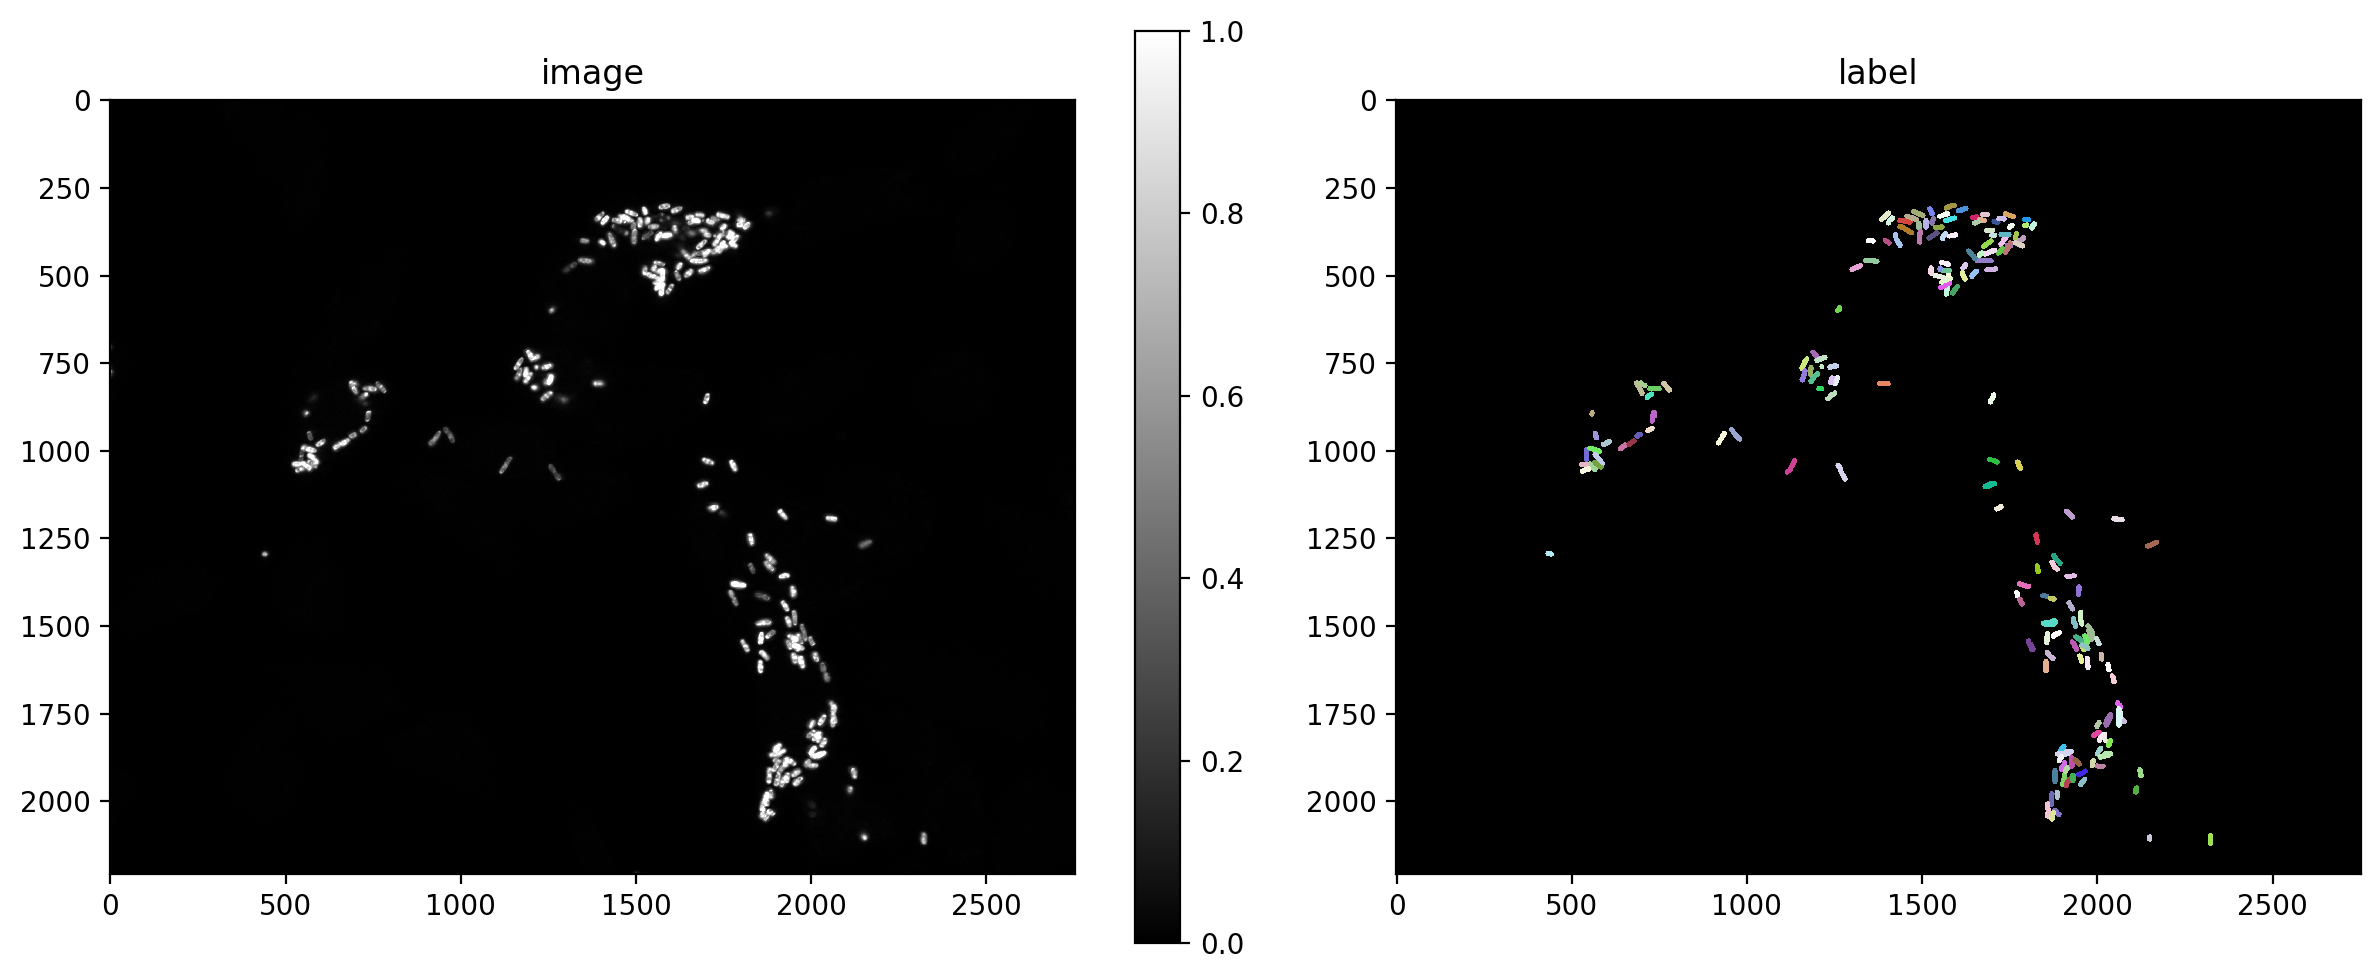

In [8]:
i = min(9, len(X_annotated)-1)
img, lbl = X_annotated[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [16]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class prediction (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [9]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [10]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [ ]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.


W0000 00:00:1756861714.637001  476725 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [15]:
import shutil
model_pretrained=StarDist2D.from_pretrained('2D_versatile_fluo')
shutil.copytree(model_pretrained.logdir, 'mymodel', dirs_exist_ok=True)
model=StarDist2D(None, 'mymodel')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [ ]:
model = StarDist2D(conf, name='', basedir='')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [12]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [26.  26.5]
network field of view :  [94 94]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [7]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

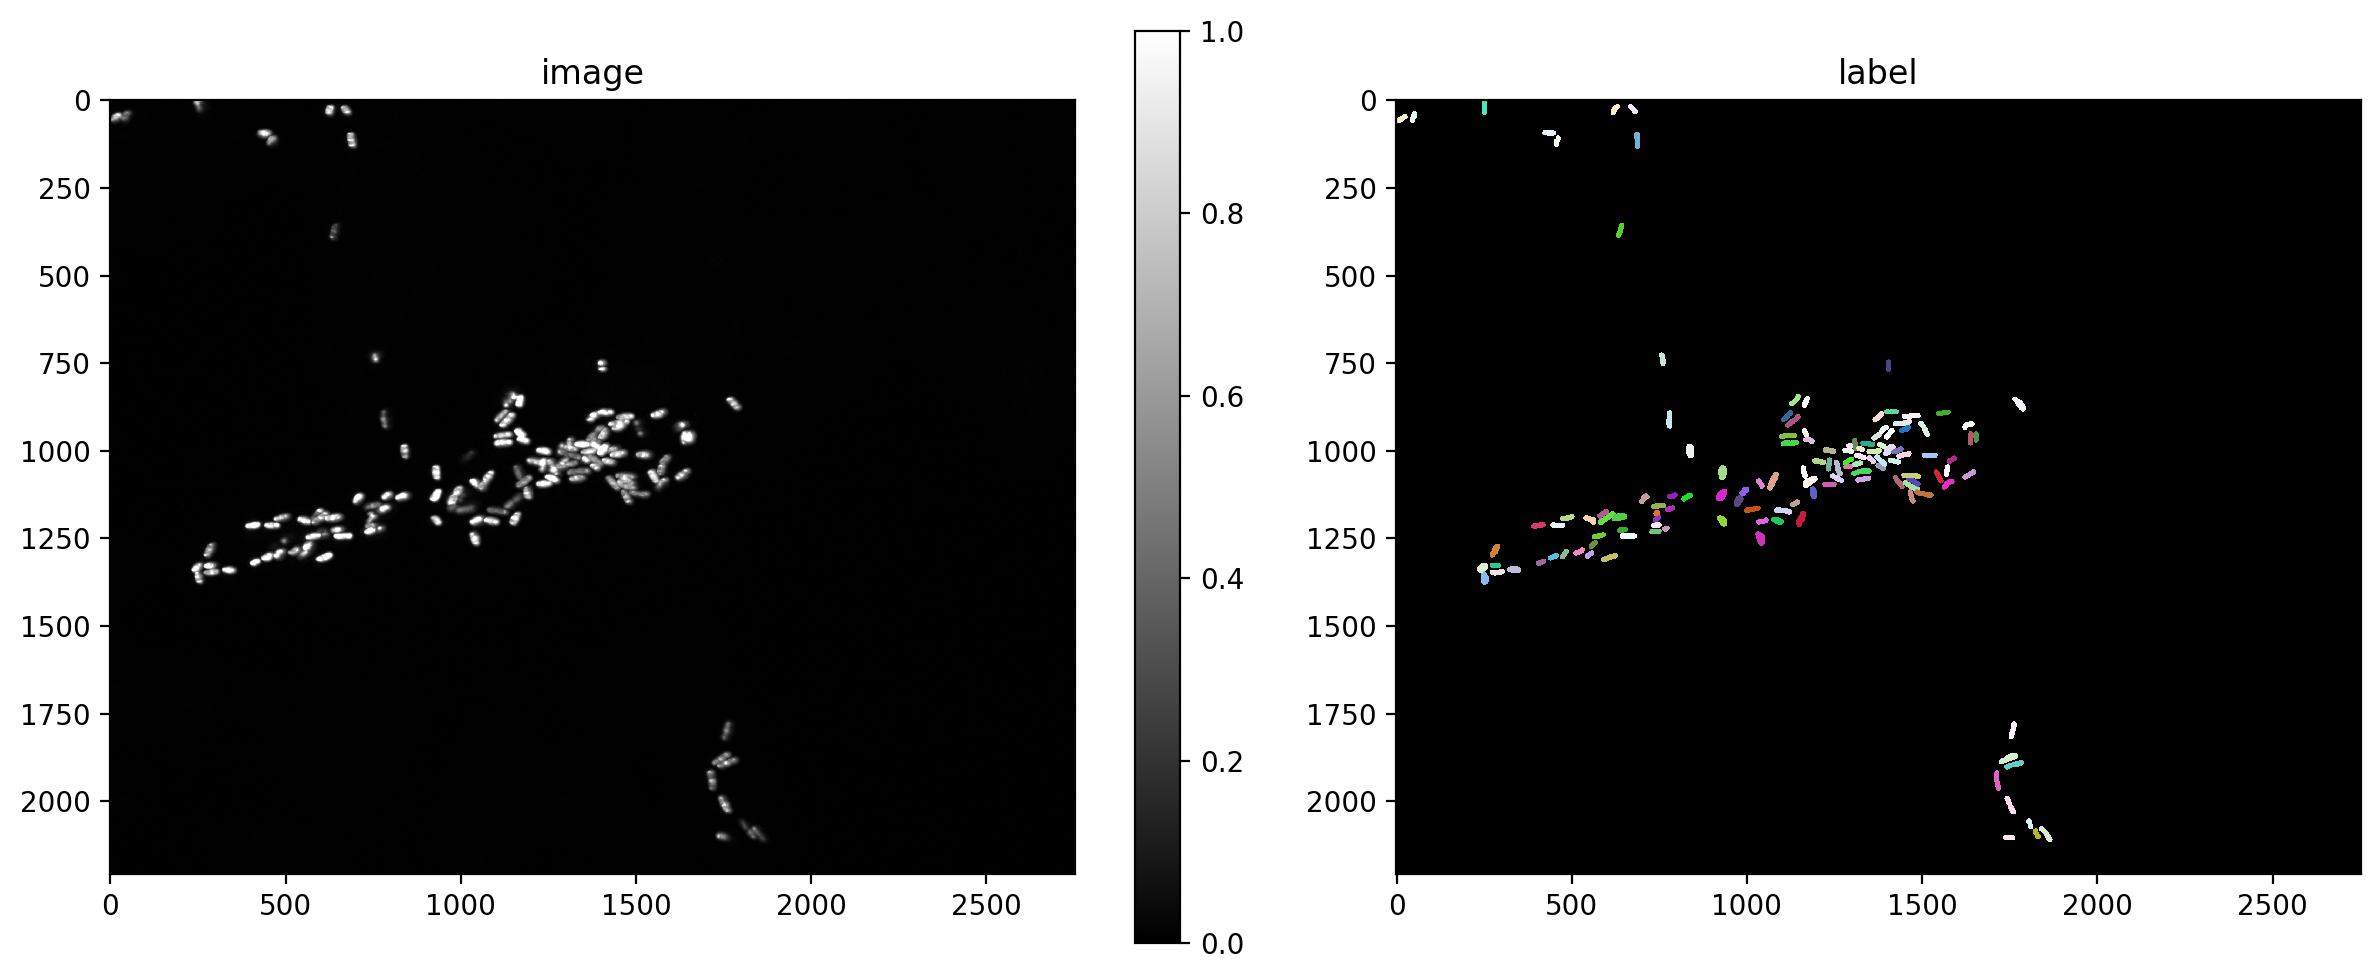

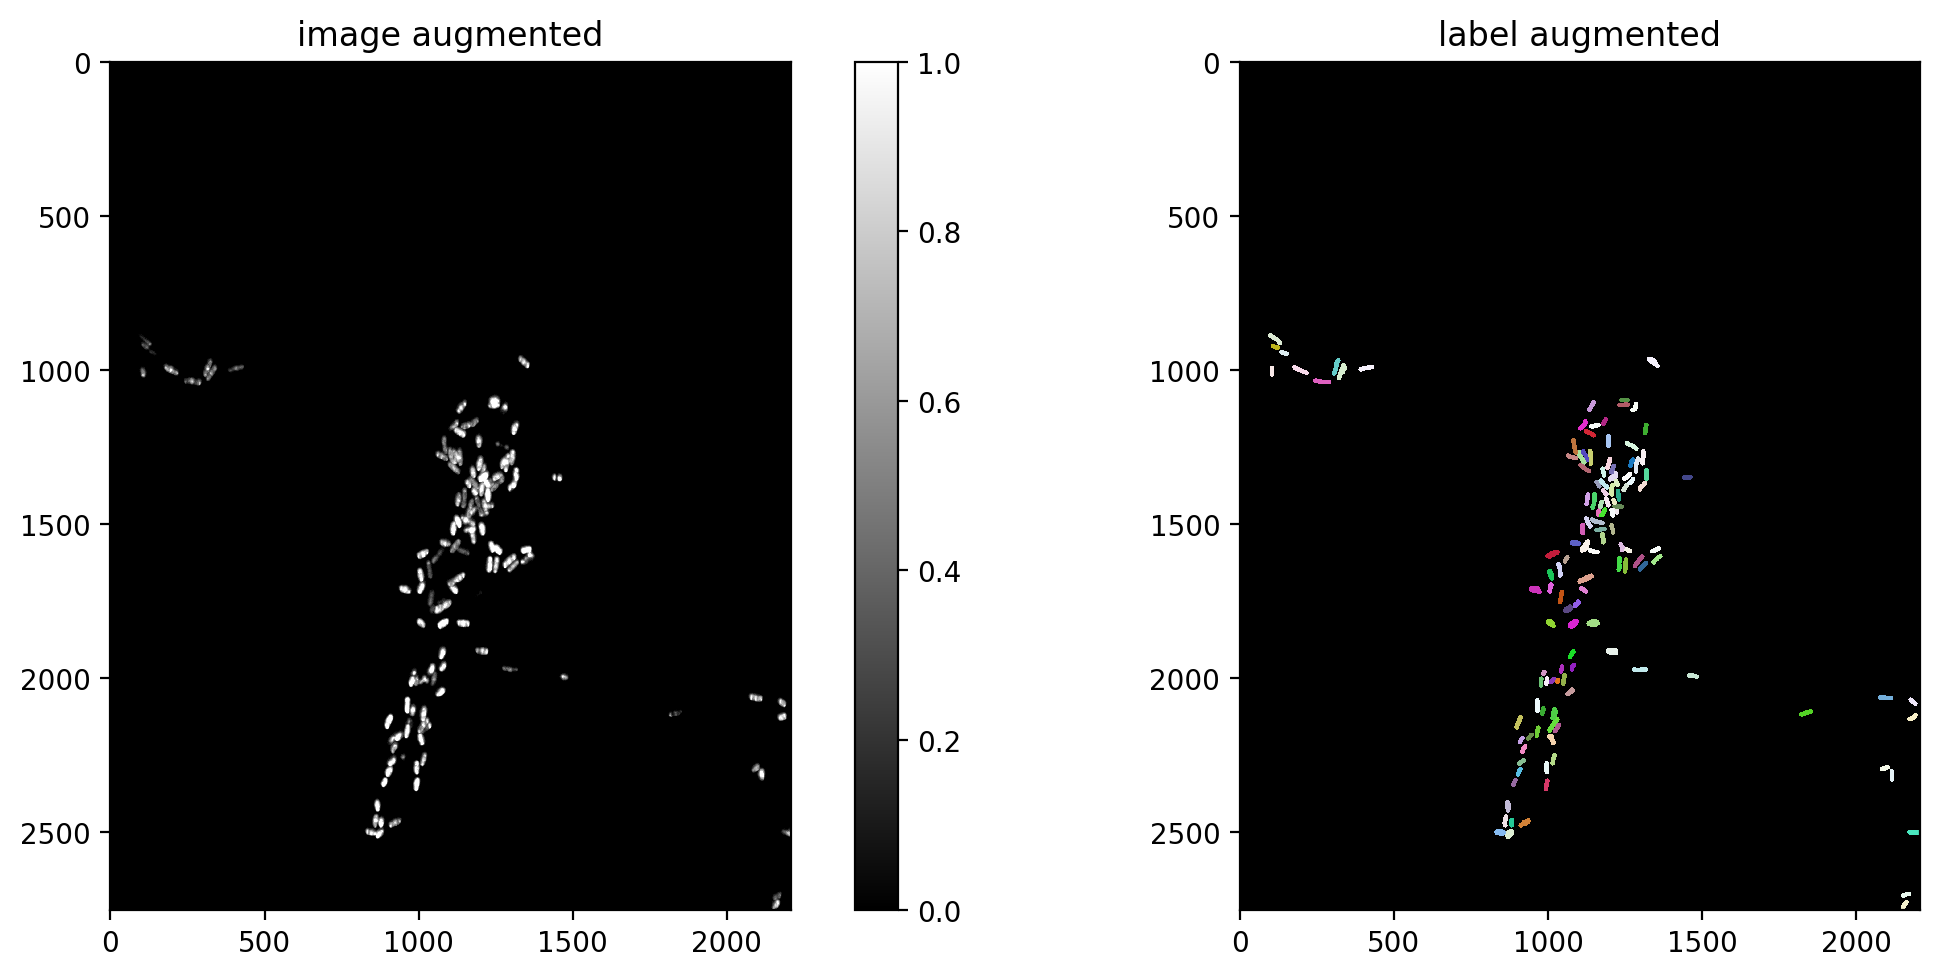

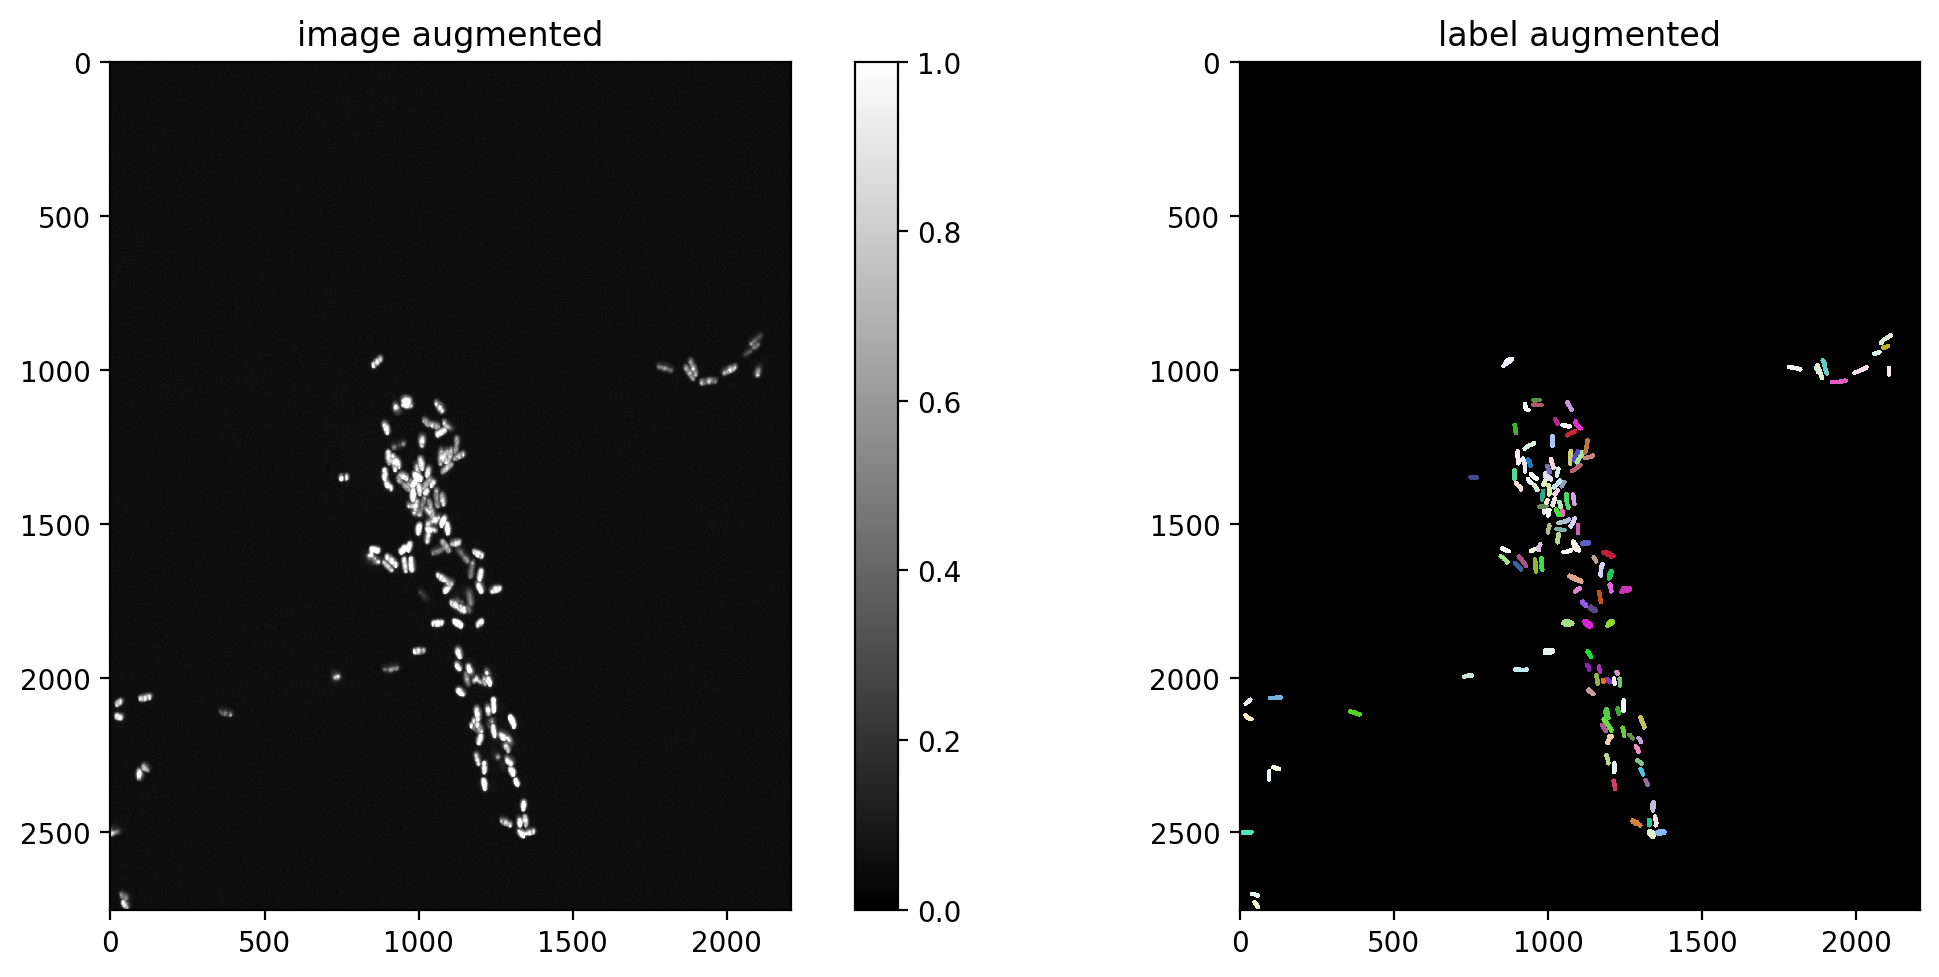

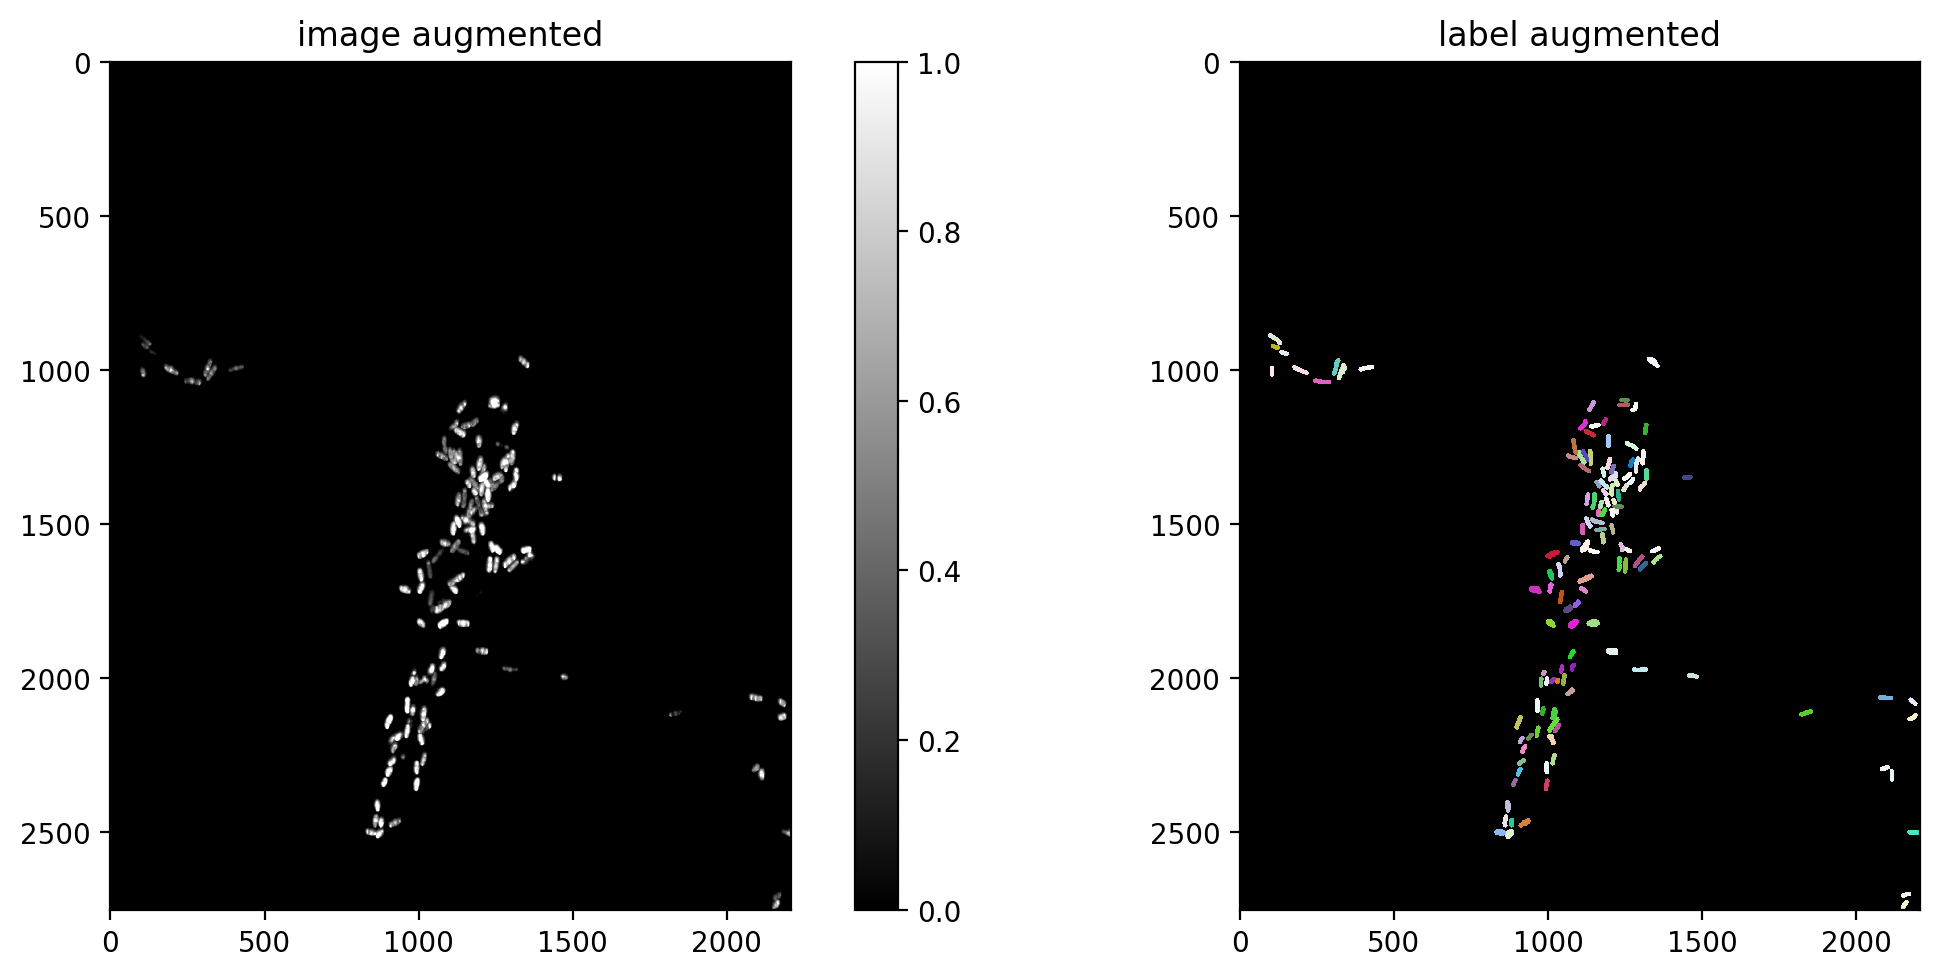

In [14]:
# plot some augmented examples
img, lbl = X_annotated[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [17]:
quick_demo = True

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=10, steps_per_epoch=10)
    

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=10)
None;

NOTE: This is only for a quick demonstration!
      Please set the variable 'quick_demo = False' for proper (long) training.


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - dist_dist_iou_metric: 0.6441 - dist_loss: 2.6459 - dist_relevant_mae: 2.6454 - dist_relevant_mse: 18.1177 - loss: 0.5738 - prob_kld: 0.0132 - prob_loss: 0.0446 - val_dist_dist_iou_metric: 0.7241 - val_dist_loss: 1.6684 - val_dist_relevant_mae: 1.6679 - val_dist_relevant_mse: 6.8867 - val_loss: 0.3382 - val_prob_kld: 9.3214e-04 - val_prob_loss: 0.0045 - learning_rate: 3.0000e-04
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - dist_dist_iou_metric: 0.6560 - dist_loss: 2.4295 - dist_relevant_mae: 2.4290 - dist_relevant_mse: 14.2926 - loss: 0.5266 - prob_kld: 0.0123 - prob_loss: 0.0407 - val_dist_dist_iou_metric: 0.7439 - val_dist_loss: 1.5449 - val_dist_relevant_mae: 1.5444 - val_dist_relevant_mse: 6.1136 - val_loss: 0.3135 - val_prob_kld: 0.0010 - val_prob_loss: 0.0046 - learning_rate: 3.0000e-04
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - dist_dist_iou_metric: 0.6533 - dist_loss: 2.5458 - dist_relevant_mae: 2.5453 - dist_re

====> Stopping training and loading previously trained demo model from disk.



Loading network weights from 'weights_best.h5'.
Found model '2D_demo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


In [ ]:
#to load a model, to store a mode

Stardist2D(None, "name_model", dir"path/to/model")

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [24]:
if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [02:29<00:49,  9.98s/it, 0.655 -> 0.469]


Using optimized values: prob_thresh=0.616822, nms_thresh=0.3.


# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [17]:
# help(matching)

First predict the labels for all validation images:

In [18]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 2/2 [00:39<00:00, 19.77s/it]


Plot a GT/prediction example 

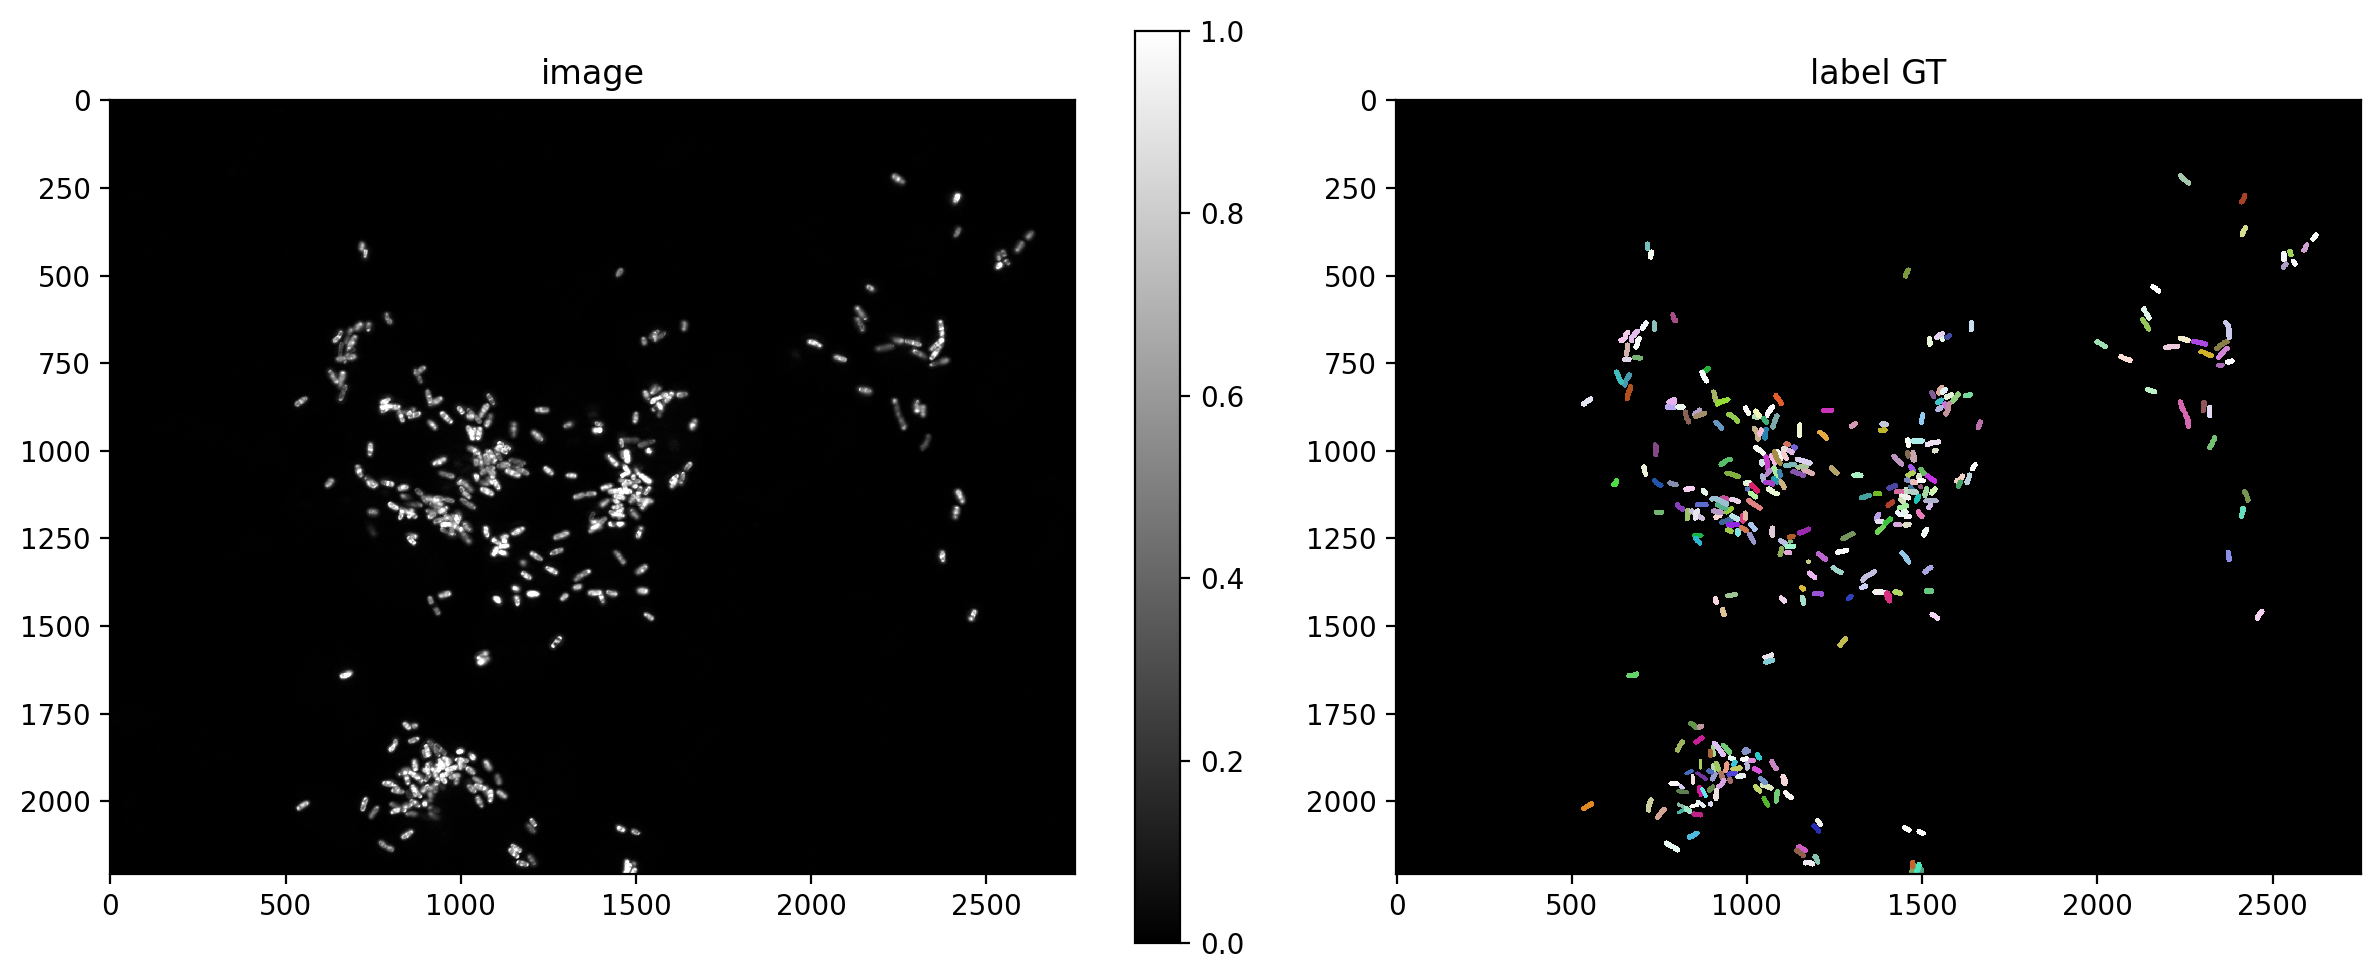

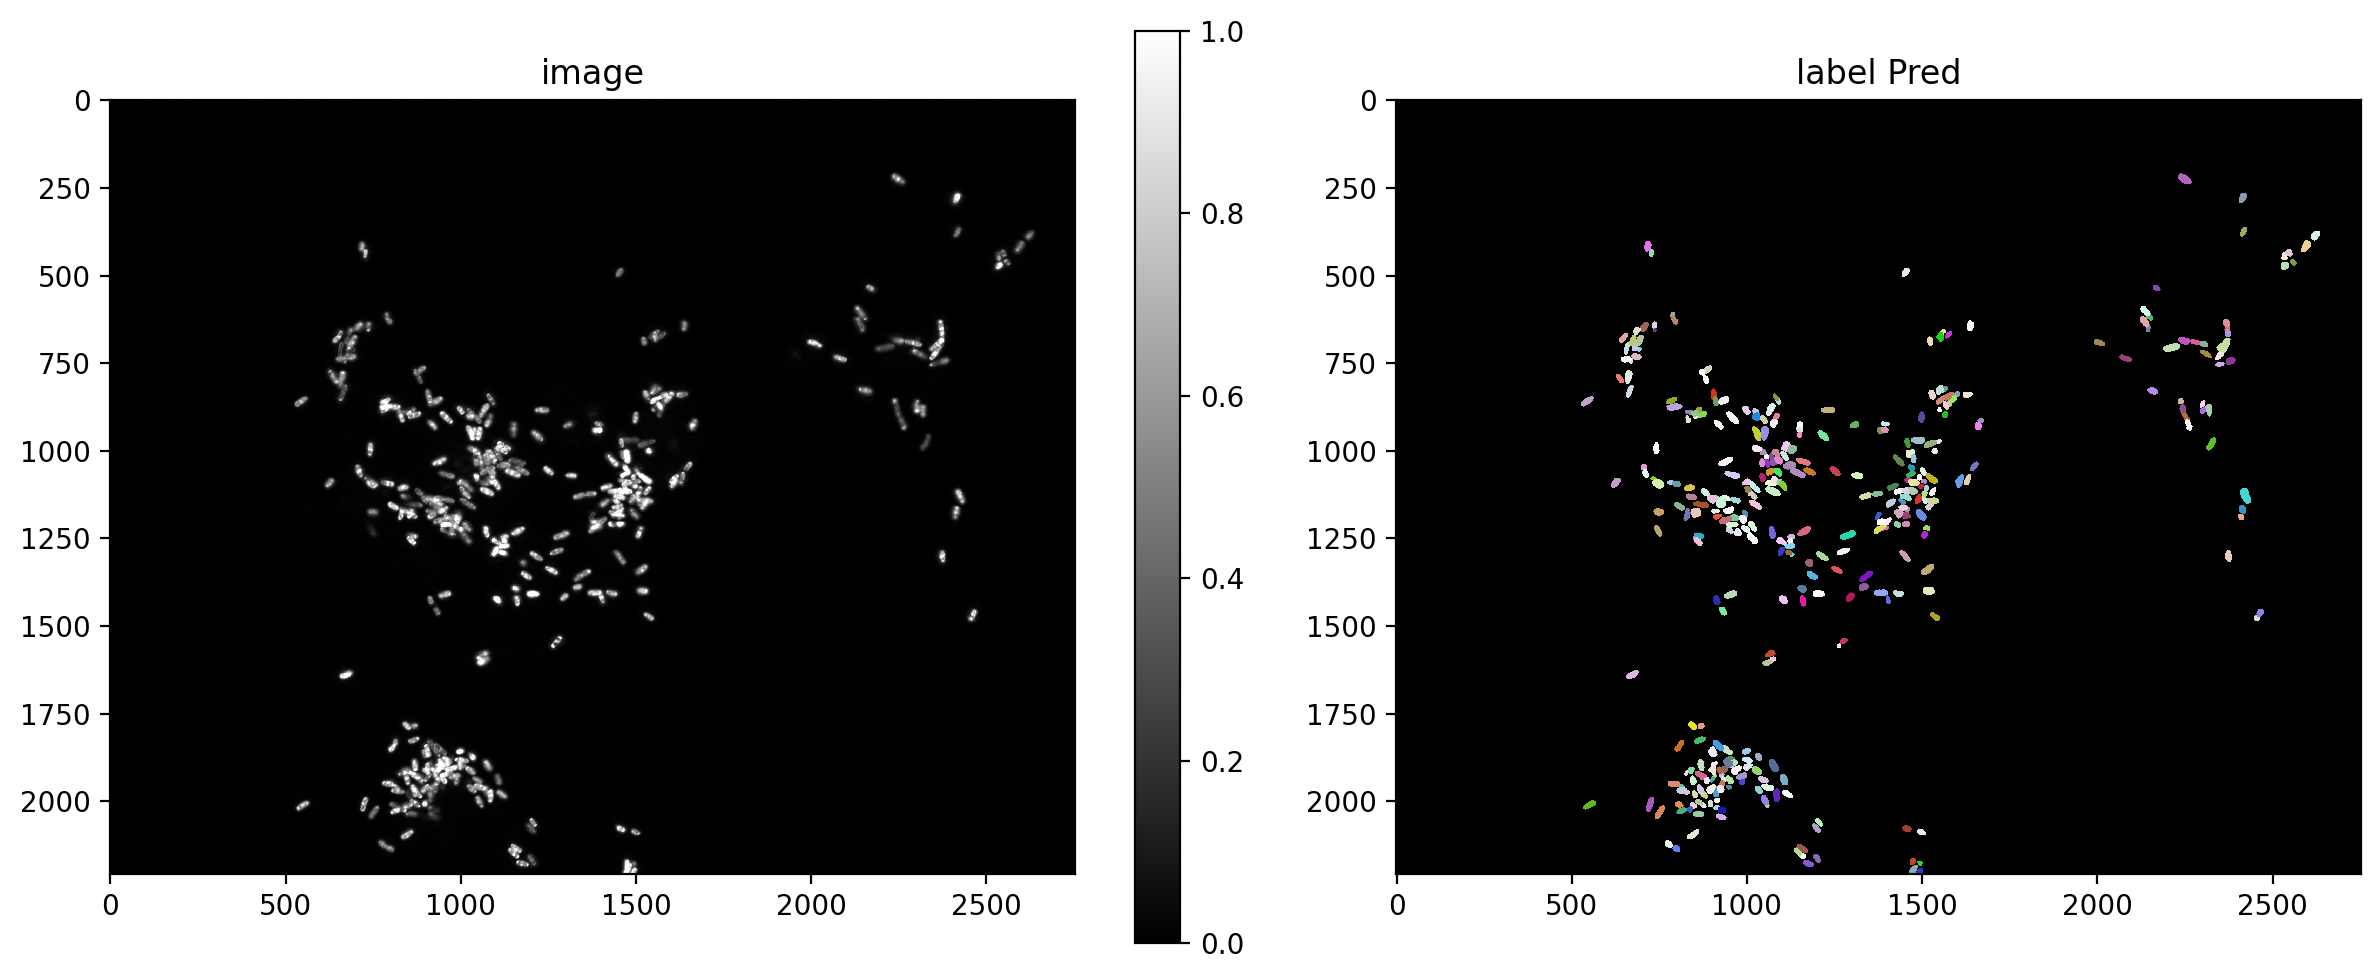

In [19]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

In [47]:
print(X_val)

[array([[ 0.0003269 ,  0.00457666,  0.00490356, ...,  0.00098071,
         0.00163452,  0.00196143],
       [ 0.00490356,  0.00424975,  0.00130762, ...,  0.00130762,
         0.00359595,  0.00261523],
       [-0.0003269 ,  0.00261523,  0.00130762, ...,  0.00163452,
         0.        ,  0.00098071],
       ...,
       [ 0.00098071,  0.00130762,  0.00228833, ...,  0.00130762,
         0.00130762,  0.00228833],
       [ 0.00261523,  0.00294214,  0.00261523, ...,  0.00196143,
         0.00065381,  0.00196143],
       [ 0.00098071,  0.00065381,  0.00326904, ...,  0.00359595,
         0.00163452,  0.00424975]], dtype=float32), array([[0.00327065, 0.00286182, 0.00245298, ..., 0.00327065, 0.0053148 ,
        0.00572363],
       [0.0053148 , 0.00204415, 0.00286182, ..., 0.00408831, 0.00327065,
        0.00286182],
       [0.00367948, 0.00572363, 0.00367948, ..., 0.00204415, 0.00081766,
        0.00449714],
       ...,
       [0.00245298, 0.00449714, 0.00327065, ..., 0.00367948, 0.00286182,
   

In [ ]:
import zarr

z= zarr.create_array(store="/mnt/efs/aimbl_2025/student_data/S-LS/cellpose_output_zarr",
   shape=(100, 100),
   chunks=(10, 10),
   dtype="f4"
)

z[:, :] = X_val

In [51]:
print(Y_val.shape)

AttributeError: 'list' object has no attribute 'shape'

In [54]:
import os
from pathlib import Path
import glob
import numpy as np
import imageio
import zarr

# Inputs
mask_dir = np.stack(Y_val)
pred_mask_dir = np.stack(Y_val_pred)
raw_bacteria_dir= np.stack(X_val)


# Output Zarr store
store_path = "/mnt/efs/aimbl_2025/student_data/S-LS/cellpose_output_zarr.zarr"
zarr.open(store_path)

# Open/create root and subgroups
root = zarr.group(store_path)


masks_grp =root.create_array(name="mask_grp", shape=(2,2208, 2752), chunks=(1,256,256), dtype="uint16")
masks_grp[:]= mask_dir

pred_grp =root.create_array(name="pred_grp", shape=(2,2208, 2752), chunks=(1,256,256), dtype="uint16")
pred_grp[:]= pred_mask_dir

raw_dir =root.create_array(name="raw_bacteria", shape=(2,2208, 2752), chunks=(1,256,256), dtype="uint16")
raw_dir[:]= raw_bacteria_dir



In [8]:
import os
os.environ["DISPLAY"] = ':1001'

In [9]:
import napari
viewer=napari.Viewer()

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [4]:
import zarr
data_sd_zarr ='/mnt/efs/aimbl_2025/student_data/S-LS/stardist_example_output_zarr.zarr'
data_sd_zarr  = zarr.open(data_sd_zarr , mode='r')

gt=data_sd_zarr ['mask_grp'][:]
raw_bacteria = data_sd_zarr ['raw_bacteria'][:]
pred = data_sd_zarr['pred_grp'][:]

In [5]:


viewer.add_image(raw_bacteria, name="raw_image")
viewer.add_labels(pred, name='prediction')
viewer.add_labels(gt, name='groundtruth')

<Labels layer 'groundtruth' at 0x74a9e0797ad0>

In [27]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:13<00:00,  1.45s/it]


Example: Print all available matching statistics for $\tau=0.5$

In [28]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=189, tp=344, fn=135, precision=0.6454033771106942, recall=0.7181628392484343, accuracy=0.5149700598802395, f1=0.6798418972332015, n_true=479, n_pred=533, mean_true_score=0.49111680446935346, mean_matched_score=0.6838515969209893, panoptic_quality=0.46491096707671997, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

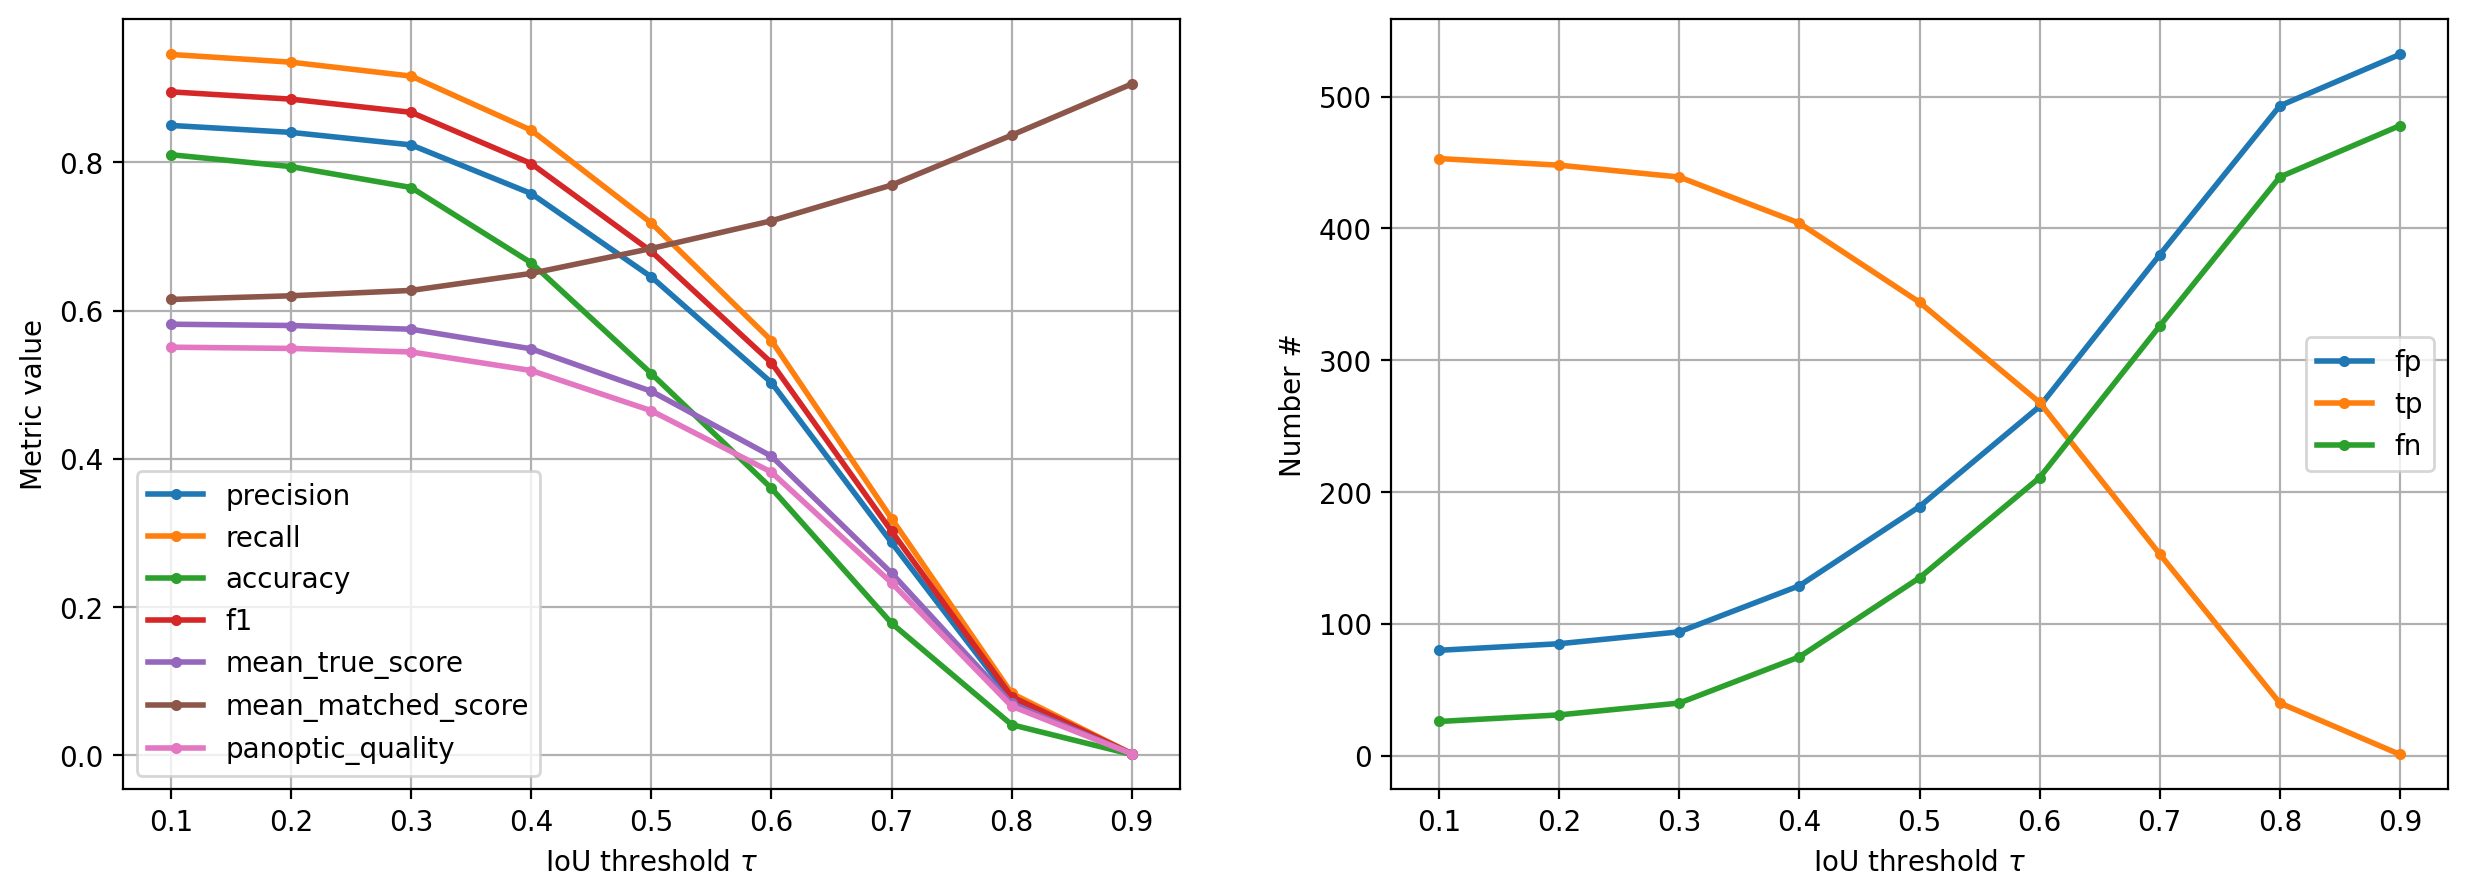

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

Testing the model

In [10]:
from stardist.models import StarDist2D

ON_Stardist_model= StarDist2D(None, "Stardist_training_model", "/home/S-LS/AI-MBL-2025/masketeers/")

W0000 00:00:1756912318.261261  521425 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [11]:
Y_val_pred = [ON_Stardist_model.predict_instances(x, n_tiles=ON_Stardist_model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 2/2 [01:11<00:00, 35.71s/it]


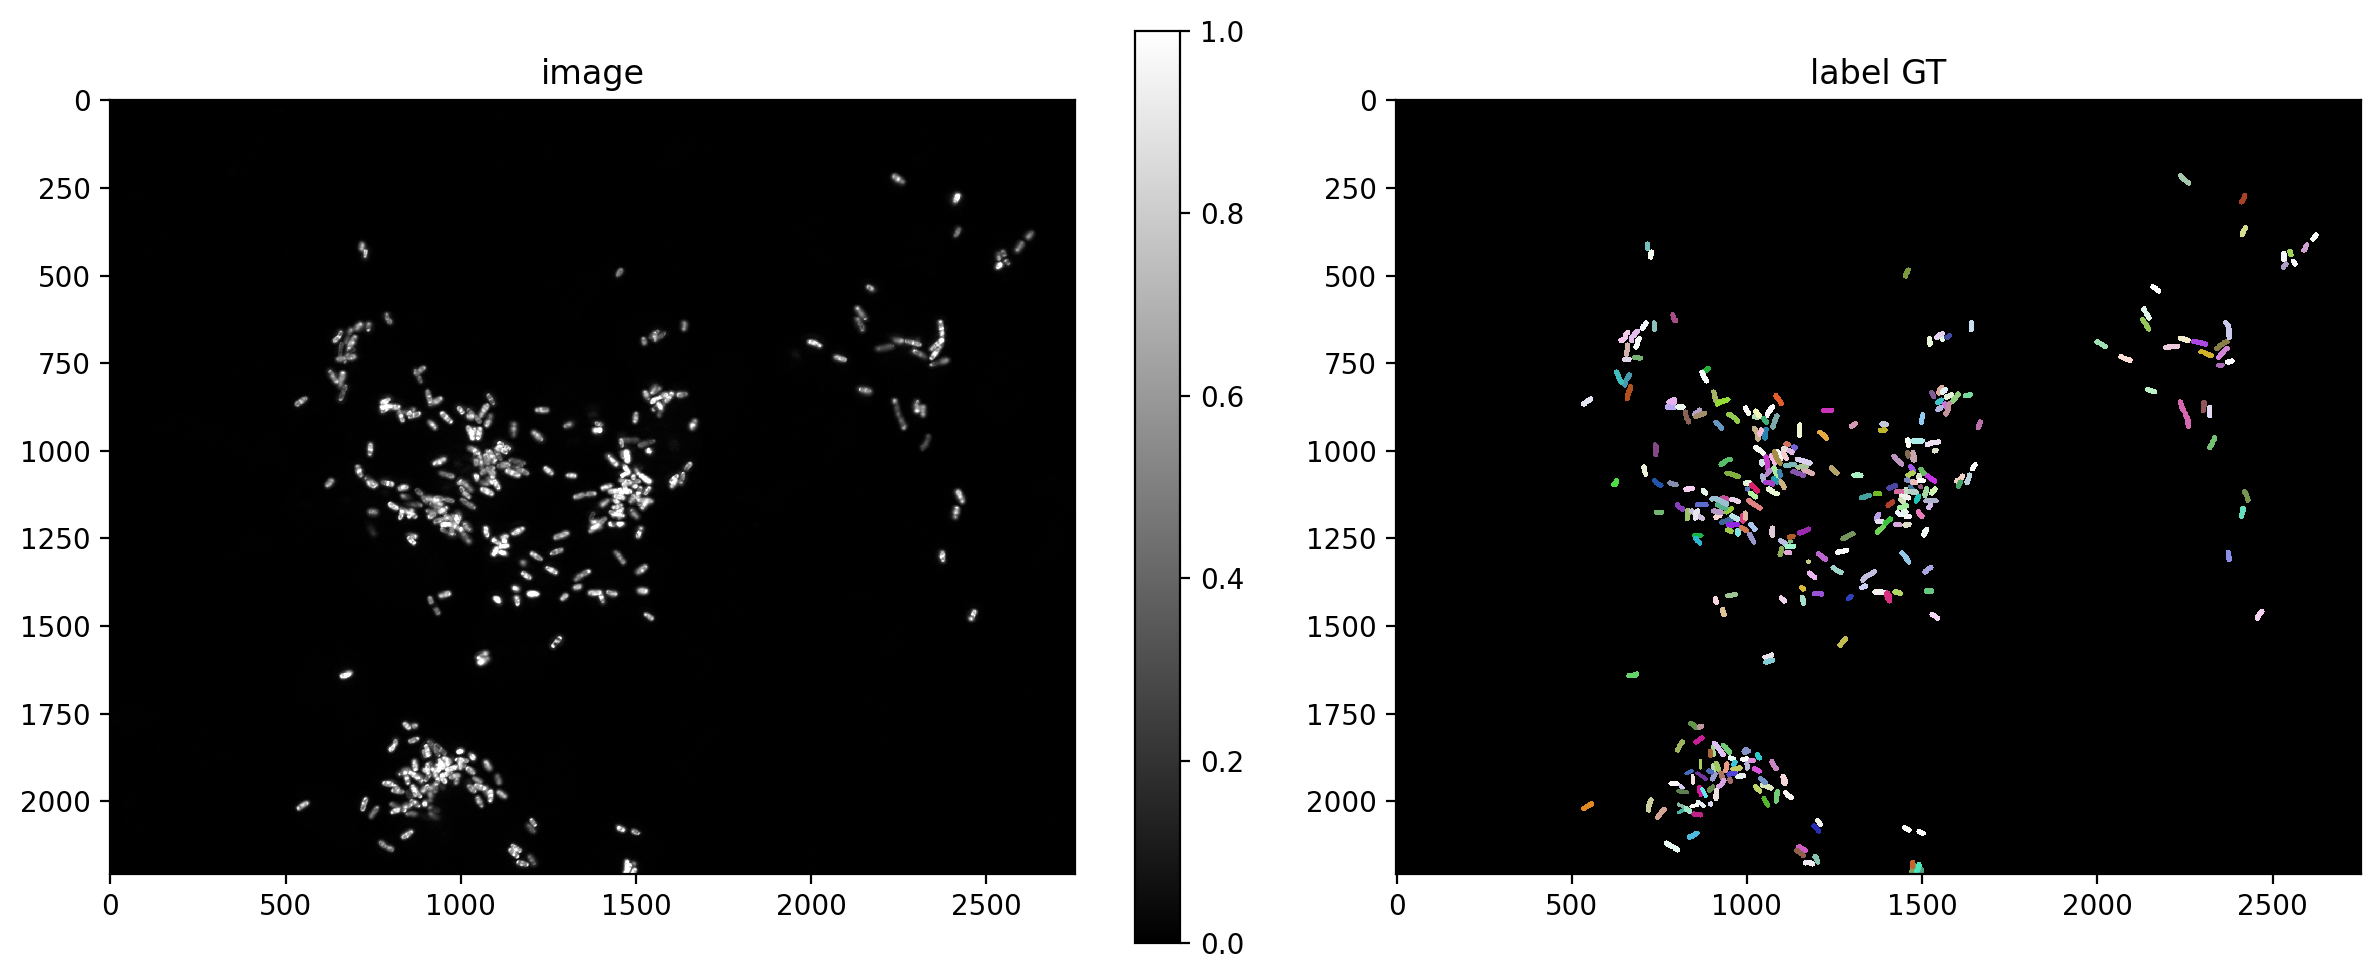

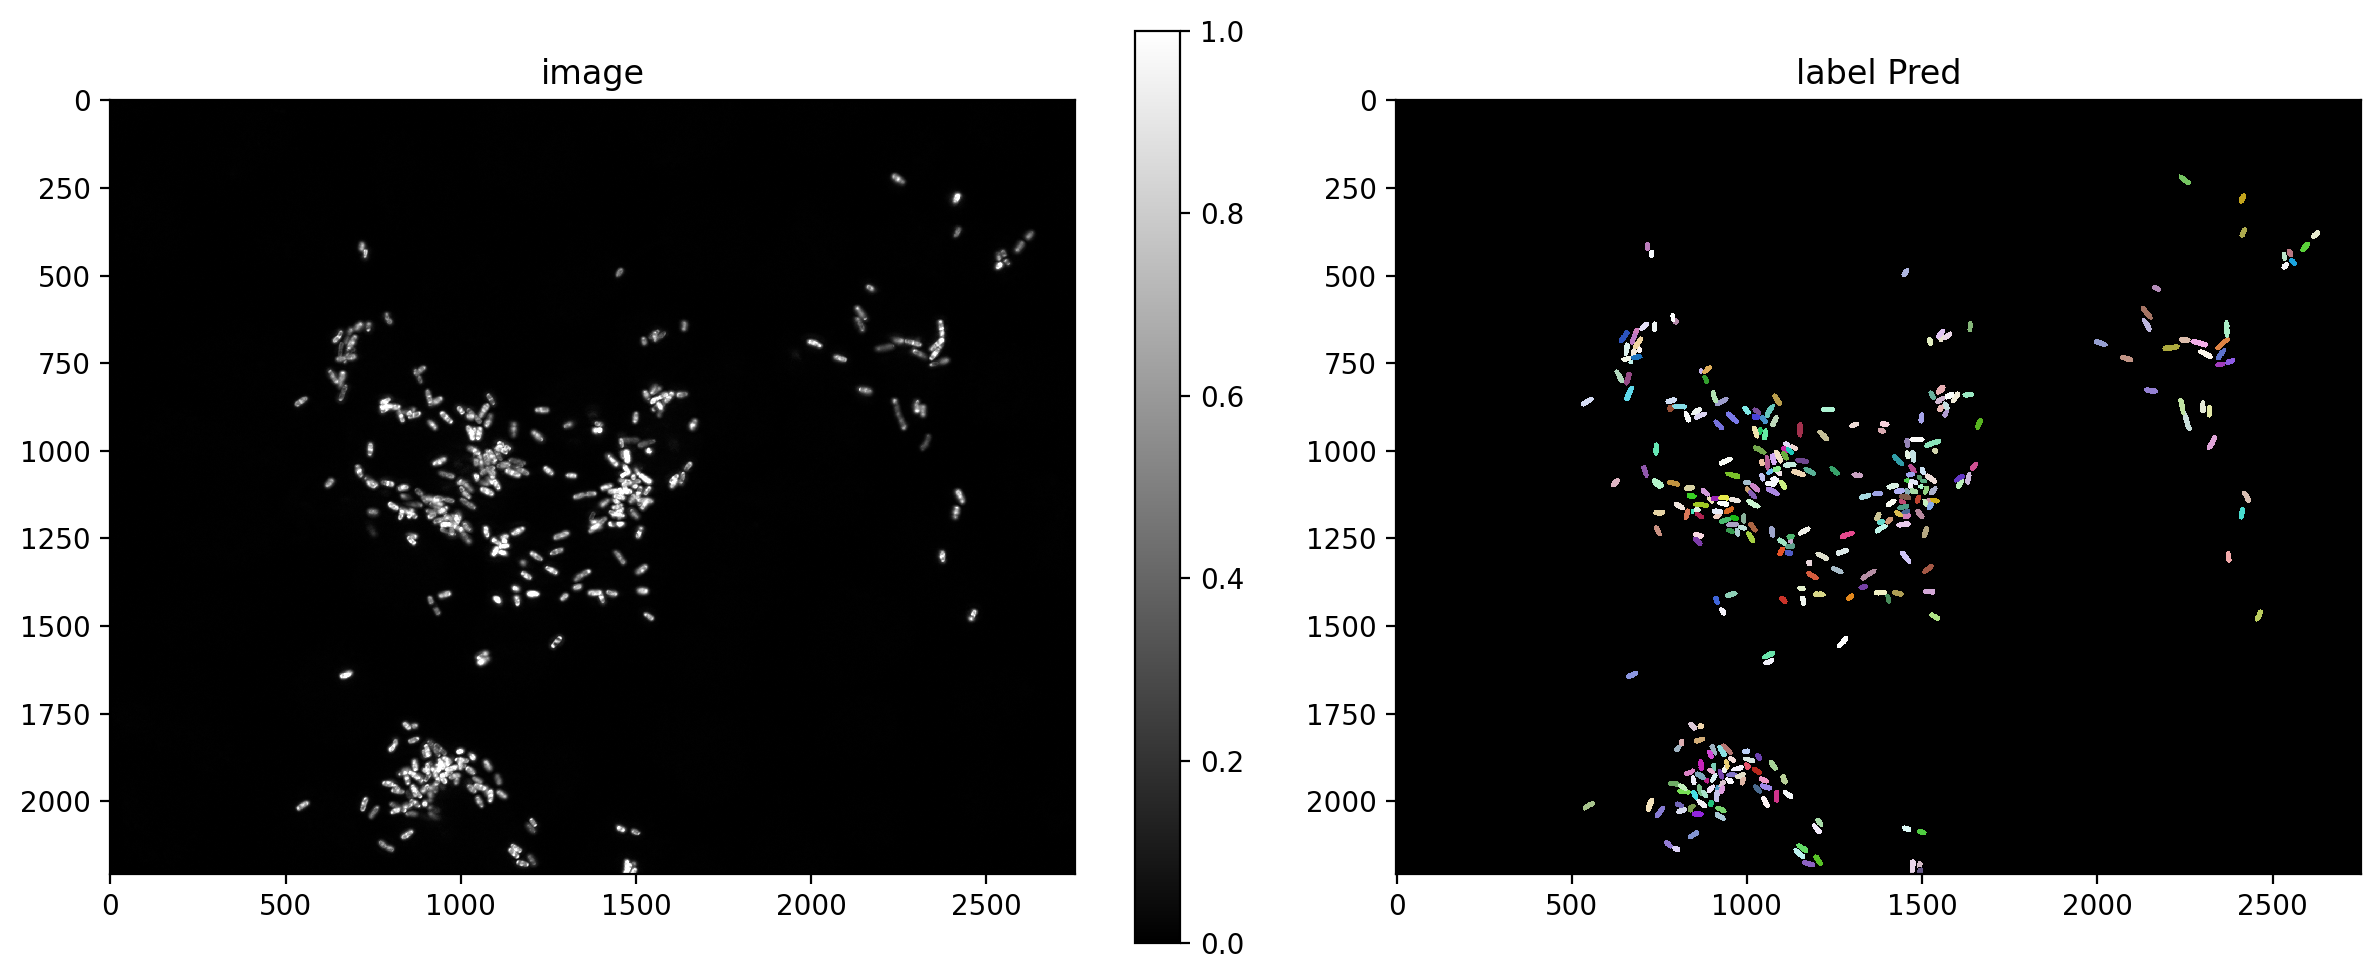

In [13]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

In [14]:


viewer.add_image(X_val[0], name="raw_image")
viewer.add_labels(Y_val_pred[0], name='prediction')
viewer.add_labels(Y_val[0],name='groundtruth')

: 